<a href="https://colab.research.google.com/github/WPHdamian/Data-Science-Curriculum-Analysis-/blob/main/02_Curriculum_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Section 2 - Curriculum Exploratory Data Analysis (EDA)

## Purpose
This notebook conducts exploratory data analysis (EDA) on the cleaned curriculum dataset
to describe and compare the structural characteristics of data science programmes in
London and Hong Kong.

The analysis focuses on:
1. Programme and module counts by city
2. Core versus elective balance
3. Programme orientation (technical vs applied)

All visual outputs are saved externally to support inclusion in the appendix of the report.


In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [48]:
import pandas as pd
import numpy as np
import os
import random
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

sns.set(style="whitegrid")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

OUTPUT_DIR = "Output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

### 2.2 Data Loading

We load the cleaned curriculum dataset produced in Notebook 1.
Only the final processed text field, biagrams and trigrams will be used for topic modelling.


In [4]:
df = pd.read_parquet("curriculum_cleaned.parquet")
df.head()

,city,university,program_name,faculty,level,module_code,module_title,module_description,core_or_elective,module_id,...,is_shared_module,text_combined,clean_text_basic,clean_text_domain,clean_text_syn,entity_tokens,clean_text_entity,clean_tokens,clean_text_final,tokens_final
0,Hong Kong,City University of Hong Kong,Bsc In Business Decision Analytics,Department of Decision Analytics and Operations,Bachelor,AC4301,Corporate Accounting II,This course aims to:\n\ndevelop students' conc...,Elective,cityu_corporate accounting ii_bachelor,...,0,Corporate Accounting II This course aims to: d...,corporate accounting ii course aim develop stu...,corporate accounting ii conceptual professiona...,corporate accounting ii conceptual professiona...,"[corporate, accounting, ii, conceptual, profes...",corporate accounting ii conceptual professiona...,"[corporate, accounting, ii, conceptual, profes...",corporate accounting ii conceptual professiona...,"[corporate, accounting, ii, conceptual, profes..."
1,Hong Kong,City University of Hong Kong,Bsc In Business Decision Analytics,Department of Decision Analytics and Operations,Bachelor,AC4342,Auditing,The primary objective of this course is to pro...,Elective,cityu_auditing_bachelor,...,0,Auditing The primary objective of this course ...,audit primary objective course provide student...,audit primary objective regulatory legal repor...,audit primary objective regulatory legal repor...,"[audit, primary_objective, regulatory, legal, ...",audit primary_objective regulatory legal repor...,"[audit, primary_objective, regulatory, legal, ...",audit primary_objective regulatory legal repor...,"[audit, primary_objective, regulatory, legal, ..."
2,Hong Kong,City University of Hong Kong,Bsc In Business Decision Analytics,Department of Decision Analytics and Operations,Bachelor,CB2100,Introduction to Financial Accounting,This course aims to:\n\nprovide students with ...,Core,cityu_introduction to financial accounting_bac...,...,0,Introduction to Financial Accounting This cour...,introduction financial accounting course aim p...,financial accounting technical processing prep...,financial accounting technical processing prep...,"[financial_accounting, technical, processing, ...",financial_accounting technical processing prep...,"[financial_accounting, technical, processing, ...",financial_accounting technical processing prep...,"[financial_accounting, technical, processing, ..."
3,Hong Kong,City University of Hong Kong,Bsc In Business Decision Analytics,Department of Decision Analytics and Operations,Bachelor,CB2101,Introduction to Managerial Accounting,This course aims to: 1.provide students with b...,Core,cityu_introduction to managerial accounting_ba...,...,0,Introduction to Managerial Accounting This cou...,introduction managerial accounting course aim ...,managerial accounting management account caree...,managerial accounting management account caree...,"[managerial_accounting, management_account, ca...",managerial_accounting management_account caree...,"[managerial_accounting, management_account, ca...",managerial_accounting management_account caree...,"[managerial_accounting, management_account, ca..."
4,Hong Kong,City University of Hong Kong,Bsc In Business Decision Analytics,Department of Decision Analytics and Operations,Bachelor,CB2200,Business Statistics,This course aims to facilitate students' learn...,Core,cityu_business statistics_bachelor,...,0,Business Statistics This course aims to facili...,business statistic course aim facilitate stude...,business statistic facilitate statistical comm...,business statistic facilitate statistical comm...,"[business, statistic, facilitate, statistical,...",business statistic facilitate statistical comm...,"[business, statistic, facilitate, statistical,...",business statistic facilitate statistical comm...,"[business, statistic, facilitate, statistical,..."


## 1. Programme and Module Counts by City

This section compares the scale of curriculum provision across cities,
measured by:
- Number of unique programmes
- Number of modules


In [7]:
programmes_per_city = (
    df[["city", "program_name"]]
    .drop_duplicates()
    .groupby("city")
    .size()
    .reset_index(name="num_programmes")
)
programmes_per_city


,city,num_programmes
0,Hong Kong,24
1,London,34


In [8]:
modules_per_city = (
    df.groupby("city")
    .size()
    .reset_index(name="num_modules")
)
modules_per_city


,city,num_modules
0,Hong Kong,852
1,London,732


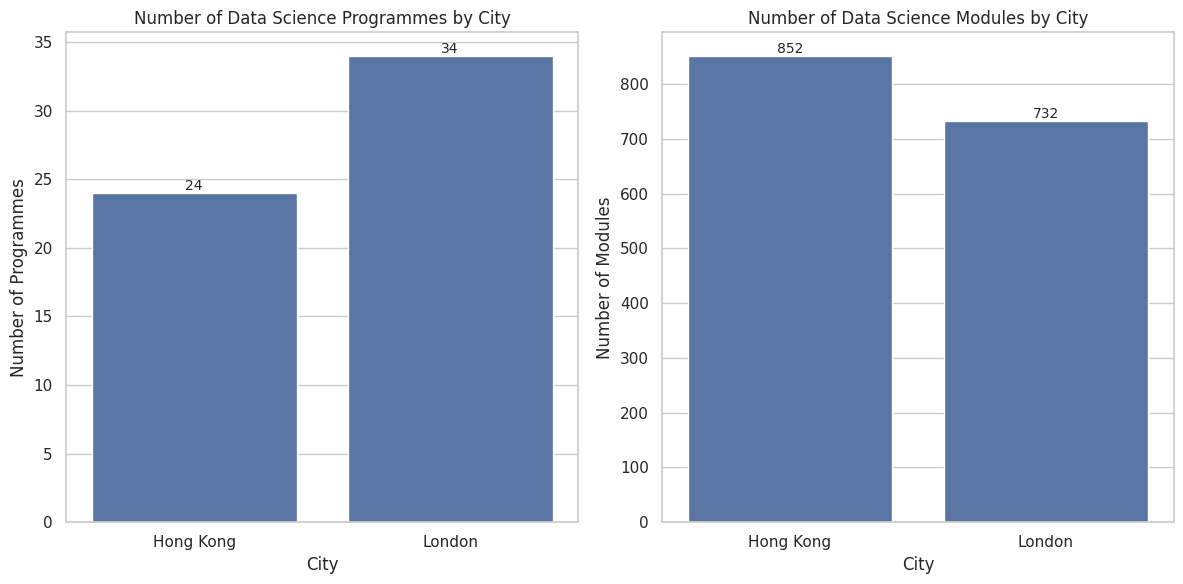

In [32]:
# Create a figure and two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))  # Two subplots side by side

# First subplot: Number of Data Science Programmes by City
sns.barplot(
    data=programmes_per_city,
    x="city",
    y="num_programmes",
    ax=axes[0]  # Use the first axis
)
axes[0].set_title("Number of Data Science Programmes by City")
axes[0].set_ylabel("Number of Programmes")
axes[0].set_xlabel("City")

# Add numbers on bars for the first subplot
for i, bar in enumerate(axes[0].containers[0]):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width() / 2.0, height, f'{int(height)}',
                 ha='center', va='bottom', fontsize=10)

# Second subplot: Number of Data Science Modules by City
sns.barplot(
    data=modules_per_city,
    x="city",
    y="num_modules",
    ax=axes[1]  # Use the second axis
)
axes[1].set_title("Number of Data Science Modules by City")
axes[1].set_ylabel("Number of Modules")
axes[1].set_xlabel("City")

# Add numbers on bars for the second subplot
for i, bar in enumerate(axes[1].containers[0]):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width() / 2.0, height, f'{int(height)}',
                 ha='center', va='bottom', fontsize=10)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig("Output/programmes_and_modules_by_city.png", dpi=300)
plt.show()

## 2. Core versus Elective Balance

Core modules typically reflect foundational disciplinary priorities,
while elective modules indicate flexibility and specialisation.
This section compares the balance between the two across cities.


In [33]:
core_elective_counts = (
    df.groupby(["city", "core_or_elective"])
    .size()
    .reset_index(name="count")
)
core_elective_counts

,city,core_or_elective,count
0,Hong Kong,Core,306
1,Hong Kong,Elective,546
2,London,Core,293
3,London,Elective,439


In [34]:
core_elective_prop = (
    core_elective_counts
    .groupby("city", group_keys=False)
    .apply(lambda x: x.assign(prop=x["count"] / x["count"].sum()))
)

core_elective_prop


,city,core_or_elective,count,prop
0,Hong Kong,Core,306,0.359155
1,Hong Kong,Elective,546,0.640845
2,London,Core,293,0.400273
3,London,Elective,439,0.599727


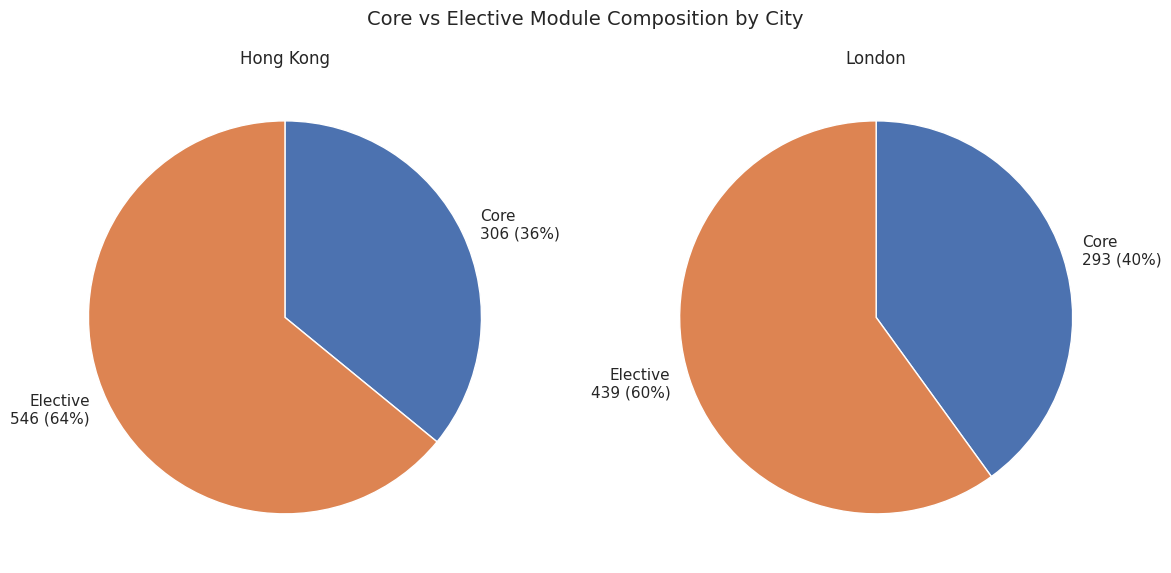

In [36]:
cities = core_elective_counts["city"].unique()

fig, axes = plt.subplots(1, len(cities), figsize=(12, 6))

if len(cities) == 1:
    axes = [axes]  # safety for single-city edge case

for ax, city in zip(axes, cities):
    subset = core_elective_counts[core_elective_counts["city"] == city]

    counts = subset["count"].values
    labels_raw = subset["core_or_elective"].values

    total = counts.sum()

    labels = [
        f"{label}\n{count} ({count/total:.0%})"
        for label, count in zip(labels_raw, counts)
    ]

    ax.pie(
        counts,
        labels=labels,
        autopct=None,
        startangle=90,
        counterclock=False
    )

    ax.set_title(f"{city}")

fig.suptitle("Core vs Elective Module Composition by City", fontsize=14)
plt.tight_layout()
plt.savefig("Output/core_vs_elective_pie_by_city.png", dpi=300)
plt.show()


## bachelor vs master

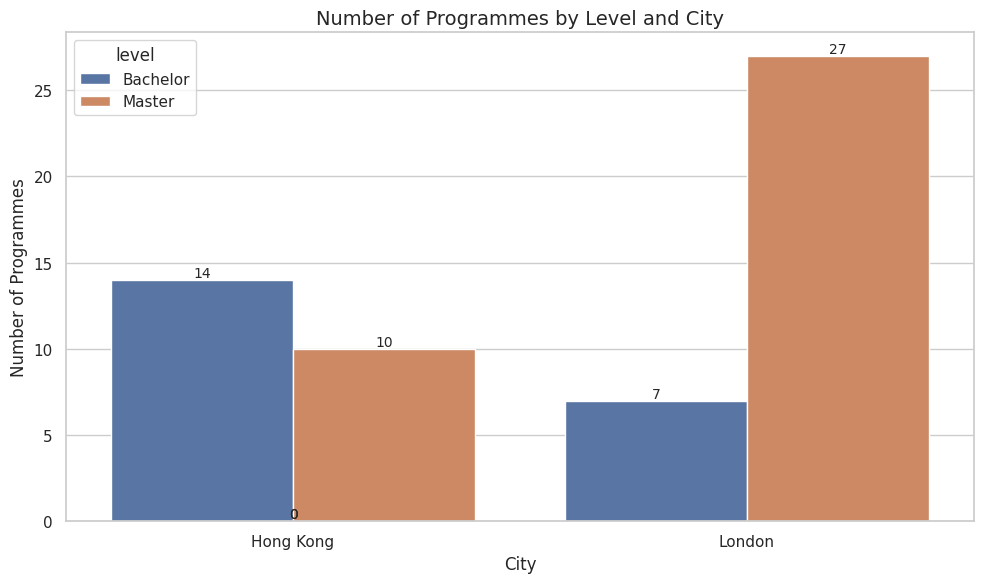

In [43]:
# Aggregate number of programmes by city and level
programme_counts = df.groupby(["city", "level"])["program_name"].nunique().reset_index()
programme_counts.rename(columns={"program_name": "programme_count"}, inplace=True)

# Plot grouped bar chart
fig, ax = plt.subplots(figsize=(10,6))

sns.barplot(
    data=programme_counts,
    x="city",
    y="programme_count",
    hue="level",
    ax=ax
)

# Add labels and title
ax.set_title("Number of Programmes by Level and City", fontsize=14)
ax.set_xlabel("City")
ax.set_ylabel("Number of Programmes")

# Annotate bars with counts
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig("Output/programme_count_by_level_city.png", dpi=300)
plt.show()

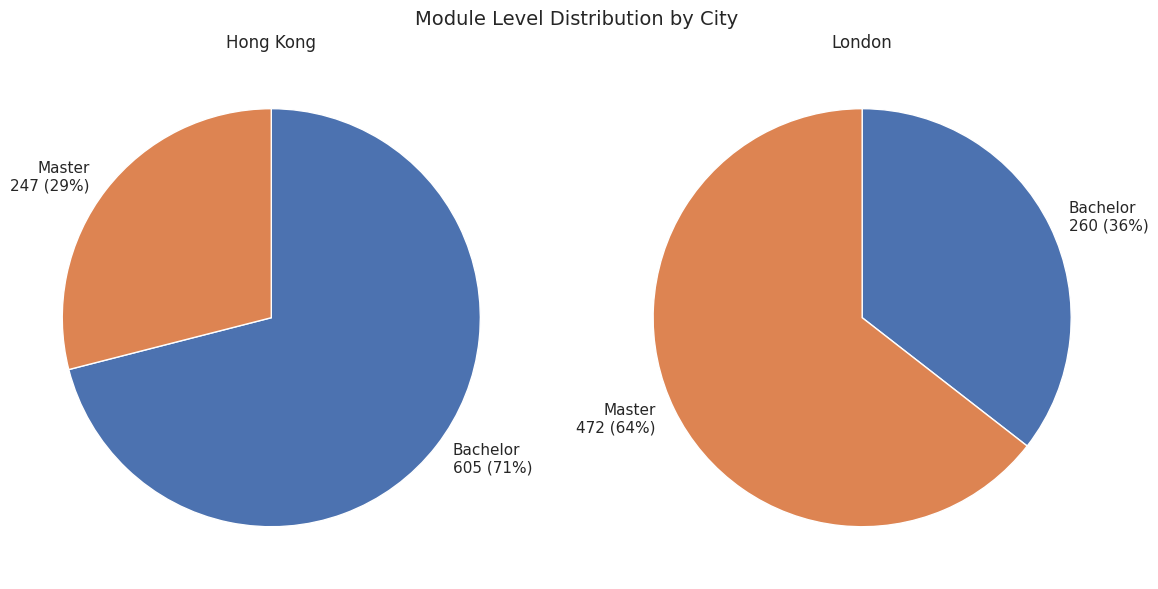

In [42]:
level_counts = df.groupby(["city", "level"]).size().reset_index(name="count")
cities = level_counts["city"].unique()

fig, axes = plt.subplots(1, len(cities), figsize=(12,6))

if len(cities) == 1:
    axes = [axes]  # safety for single-city case

for ax, city in zip(axes, cities):
    subset = level_counts[level_counts["city"] == city]
    counts = subset["count"].values
    labels_raw = subset["level"].values
    total = counts.sum()

    # Add count and percentage to label
    labels = [f"{label}\n{count} ({count/total:.0%})"
              for label, count in zip(labels_raw, counts)]

    ax.pie(
        counts,
        labels=labels,
        autopct=None,
        startangle=90,
        counterclock=False
    )
    ax.set_title(f"{city}")

fig.suptitle("Module Level Distribution by City", fontsize=14)
plt.tight_layout()
plt.savefig("Output/module_level_pie_by_city.png", dpi=300)
plt.show()

## 3. Programme Orientation: Technical vs Applied

To approximate pedagogical orientation, modules are classified using
keyword-based heuristics applied to cleaned text.

This is an exploratory proxy, not a definitive classification.


In [18]:
technical_keywords = [
    "algorithm", "machine learning", "statistics", "optimization",
    "database", "programming", "python", "sql", "model", "theory"
]

applied_keywords = [
    "business", "decision", "application", "case", "project",
    "industry", "management", "strategy", "communication", "internship"
]

def classify_orientation(text):
    tech_score = sum(kw in text for kw in technical_keywords)
    app_score = sum(kw in text for kw in applied_keywords)

    if tech_score > app_score:
        return "Technical"
    elif app_score > tech_score:
        return "Applied"
    else:
        return "Mixed"



In [19]:
df["orientation"] = df["clean_text_final"].astype(str).apply(classify_orientation)
df["orientation"].value_counts()


,count
orientation,
Applied,586
Technical,532
Mixed,466


In [20]:
orientation_dist = (
    df.groupby(["city", "orientation"])
    .size()
    .reset_index(name="count")
)

orientation_prop = (
    orientation_dist
    .groupby("city", group_keys=False)
    .apply(lambda x: x.assign(prop=x["count"] / x["count"].sum()))
)


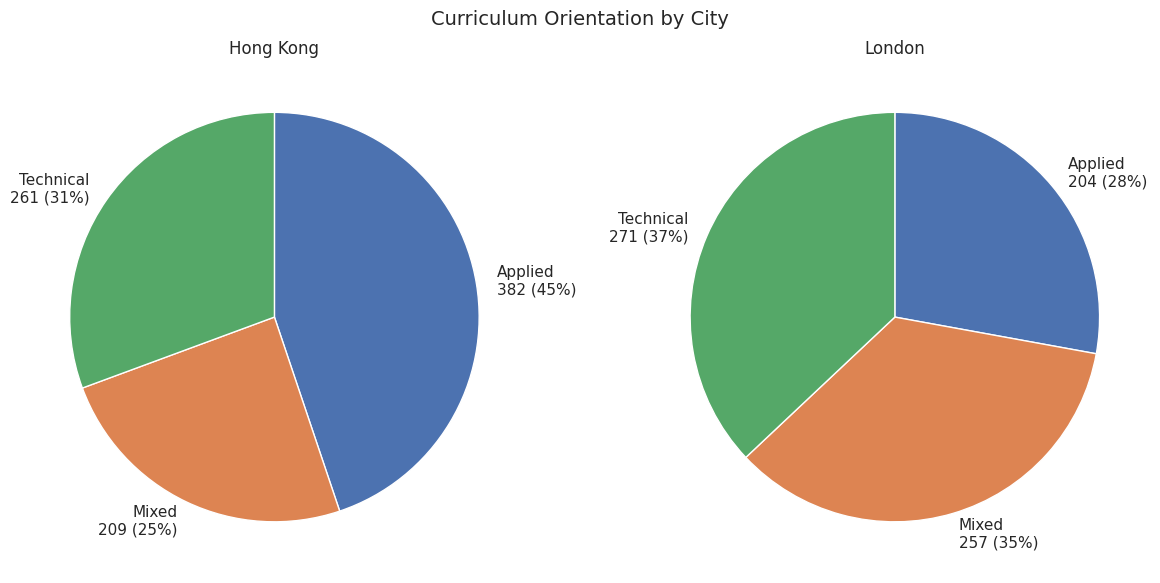

In [38]:
# Ensure you have counts per orientation per city
orientation_counts = df.groupby(["city", "orientation"]).size().reset_index(name="count")

cities = orientation_counts["city"].unique()

fig, axes = plt.subplots(1, len(cities), figsize=(12,6))

if len(cities) == 1:
    axes = [axes]  # safety for single-city case

for ax, city in zip(axes, cities):
    subset = orientation_counts[orientation_counts["city"] == city]

    counts = subset["count"].values
    labels_raw = subset["orientation"].values
    total = counts.sum()

    # Add count and percentage to label
    labels = [f"{label}\n{count} ({count/total:.0%})"
              for label, count in zip(labels_raw, counts)]

    ax.pie(
        counts,
        labels=labels,
        autopct=None,
        startangle=90,
        counterclock=False
    )
    ax.set_title(f"{city}")

fig.suptitle("Curriculum Orientation by City", fontsize=14)
plt.tight_layout()
plt.savefig("Output/programme_orientation_pie_by_city.png", dpi=300)
plt.show()


### 2.3 Frequency analysis

### Output Produced
- tokenised corpus  
- top 25 most frequent unigrams  
- top 25 most frequent bigrams/trigrams  
- bar charts with frequency counts  


In [45]:
# Extract all tokens from the final cleaned text
df["tokens_final"] = df["clean_text_final"].apply(lambda x: x.split())

# Flatten list for global frequency counts
all_tokens = [token for tokens in df["tokens_final"] for token in tokens]

len(all_tokens), len(set(all_tokens))

(68657, 8639)

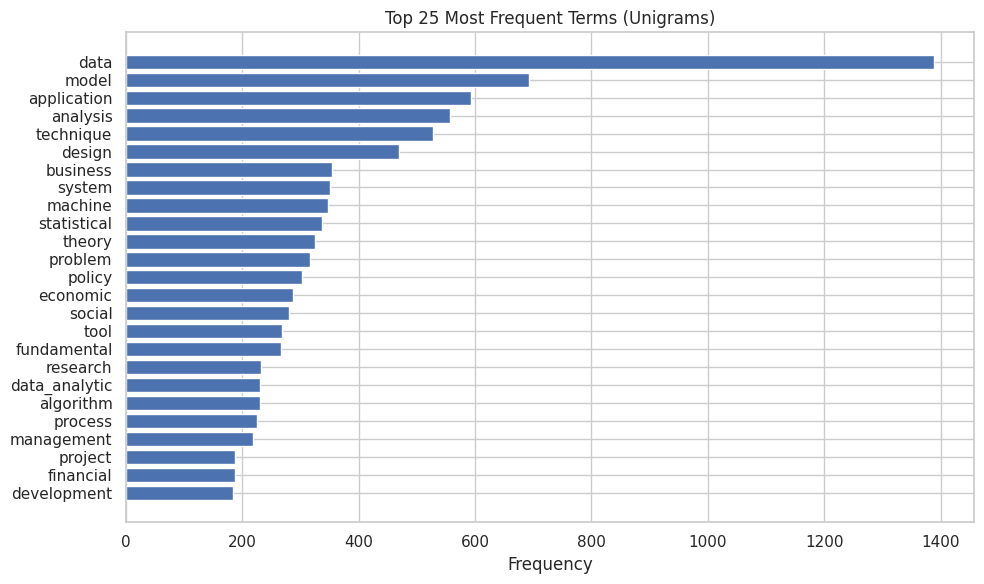

In [47]:
unigram_freq = Counter(all_tokens)
top_unigrams = unigram_freq.most_common(25)

# Convert to DataFrame
uni_df = pd.DataFrame(top_unigrams, columns=["term", "frequency"])

# Plot
plt.figure(figsize=(10, 6))
plt.barh(uni_df["term"], uni_df["frequency"])
plt.title("Top 25 Most Frequent Terms (Unigrams)")
plt.xlabel("Frequency")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("Output/requent_terms.png", dpi=300)
plt.show()


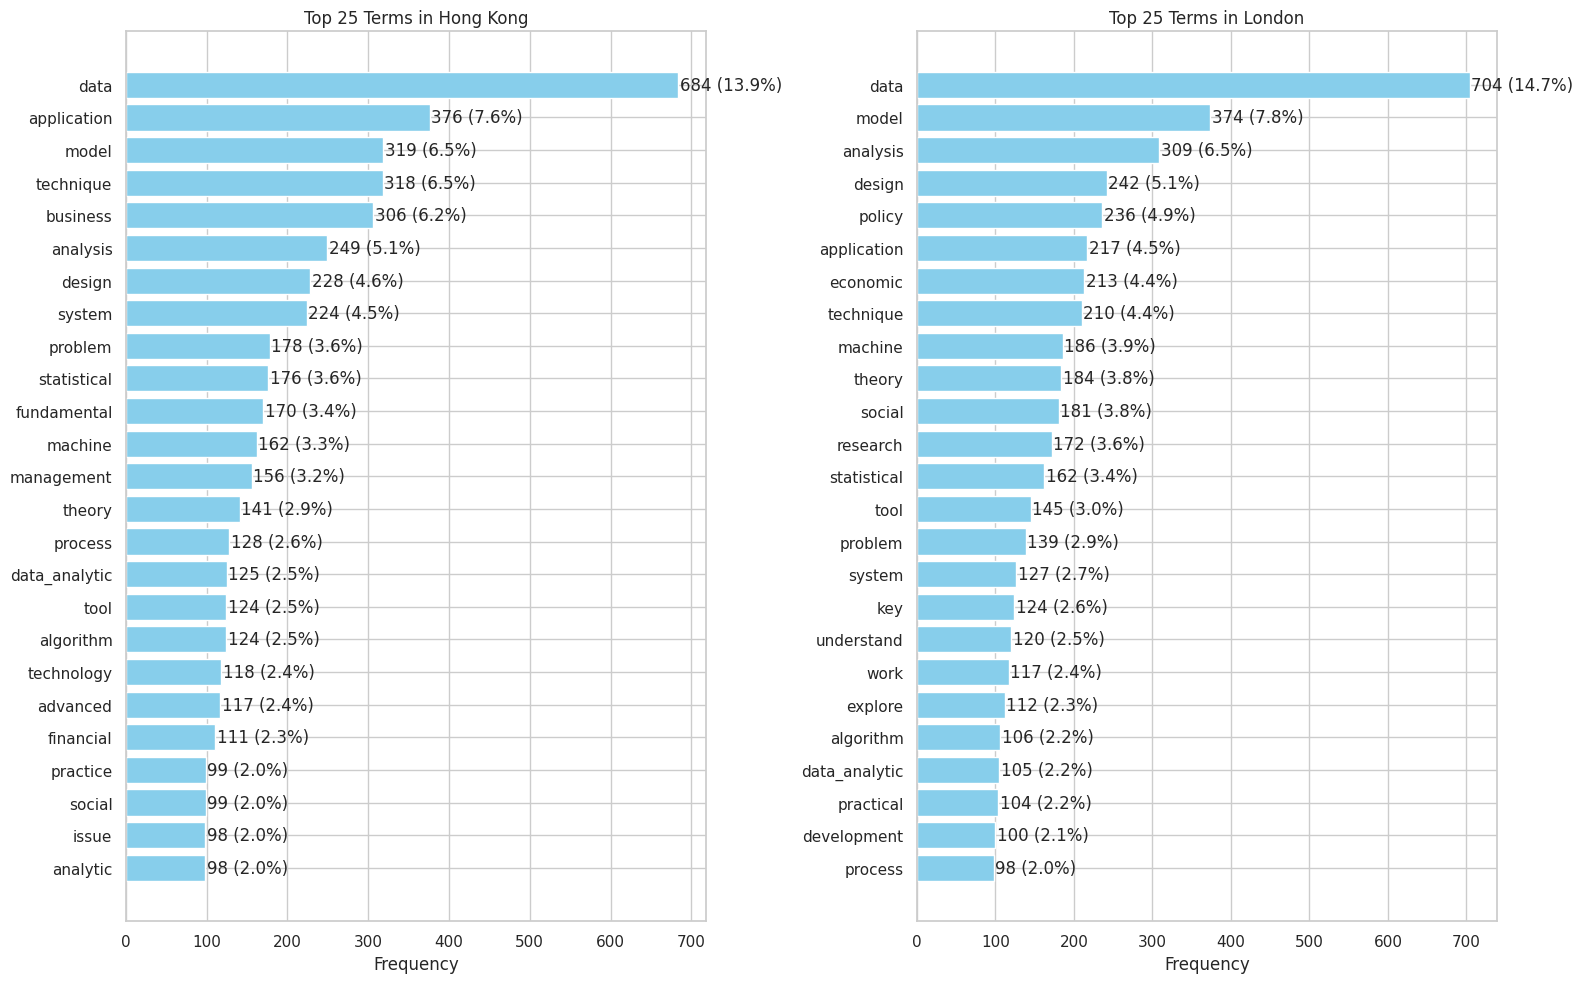

In [50]:
cities = df["city"].unique()
fig, axes = plt.subplots(1, 2, figsize=(16, 10))

for ax, city in zip(axes, cities):
    city_tokens = [token for tokens in df[df["city"]==city]["tokens_final"] for token in tokens]
    counter = Counter(city_tokens)
    top_tokens = counter.most_common(25)

    top_df = pd.DataFrame(top_tokens, columns=["term", "frequency"])
    total_tokens = top_df["frequency"].sum()
    top_df["percent"] = top_df["frequency"] / total_tokens * 100

    # Horizontal bar chart, independent y-axis
    ax.barh(top_df["term"], top_df["frequency"], color="skyblue")

    # Annotate counts and percentages
    for i, row in top_df.iterrows():
        ax.text(row["frequency"] + 2, i, f'{row["frequency"]} ({row["percent"]:.1f}%)', va='center')

    ax.set_title(f"Top 25 Terms in {city}")
    ax.set_xlabel("Frequency")
    ax.invert_yaxis()  # Highest frequency at top

plt.tight_layout()
plt.savefig("Output/top_tokens_by_city_fixed.png", dpi=300)
plt.show()

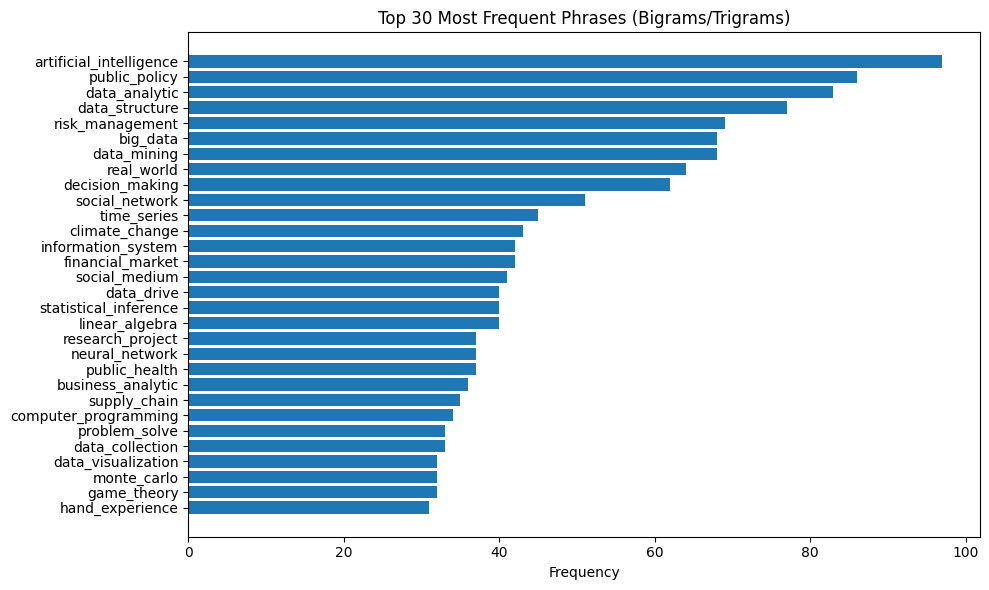

In [ ]:
# Extract multi-word expressions (tokens containing '_')
multiword_tokens = [t for t in all_tokens if "_" in t]

multiword_freq = Counter(multiword_tokens)
top_multi = multiword_freq.most_common(30)

multi_df = pd.DataFrame(top_multi, columns=["term", "frequency"])

# Plot
plt.figure(figsize=(10, 6))
plt.barh(multi_df["term"], multi_df["frequency"])
plt.title("Top 30 Most Frequent Phrases (Bigrams/Trigrams)")
plt.xlabel("Frequency")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("Output/frequent_phrases.png", dpi=300)
plt.show()

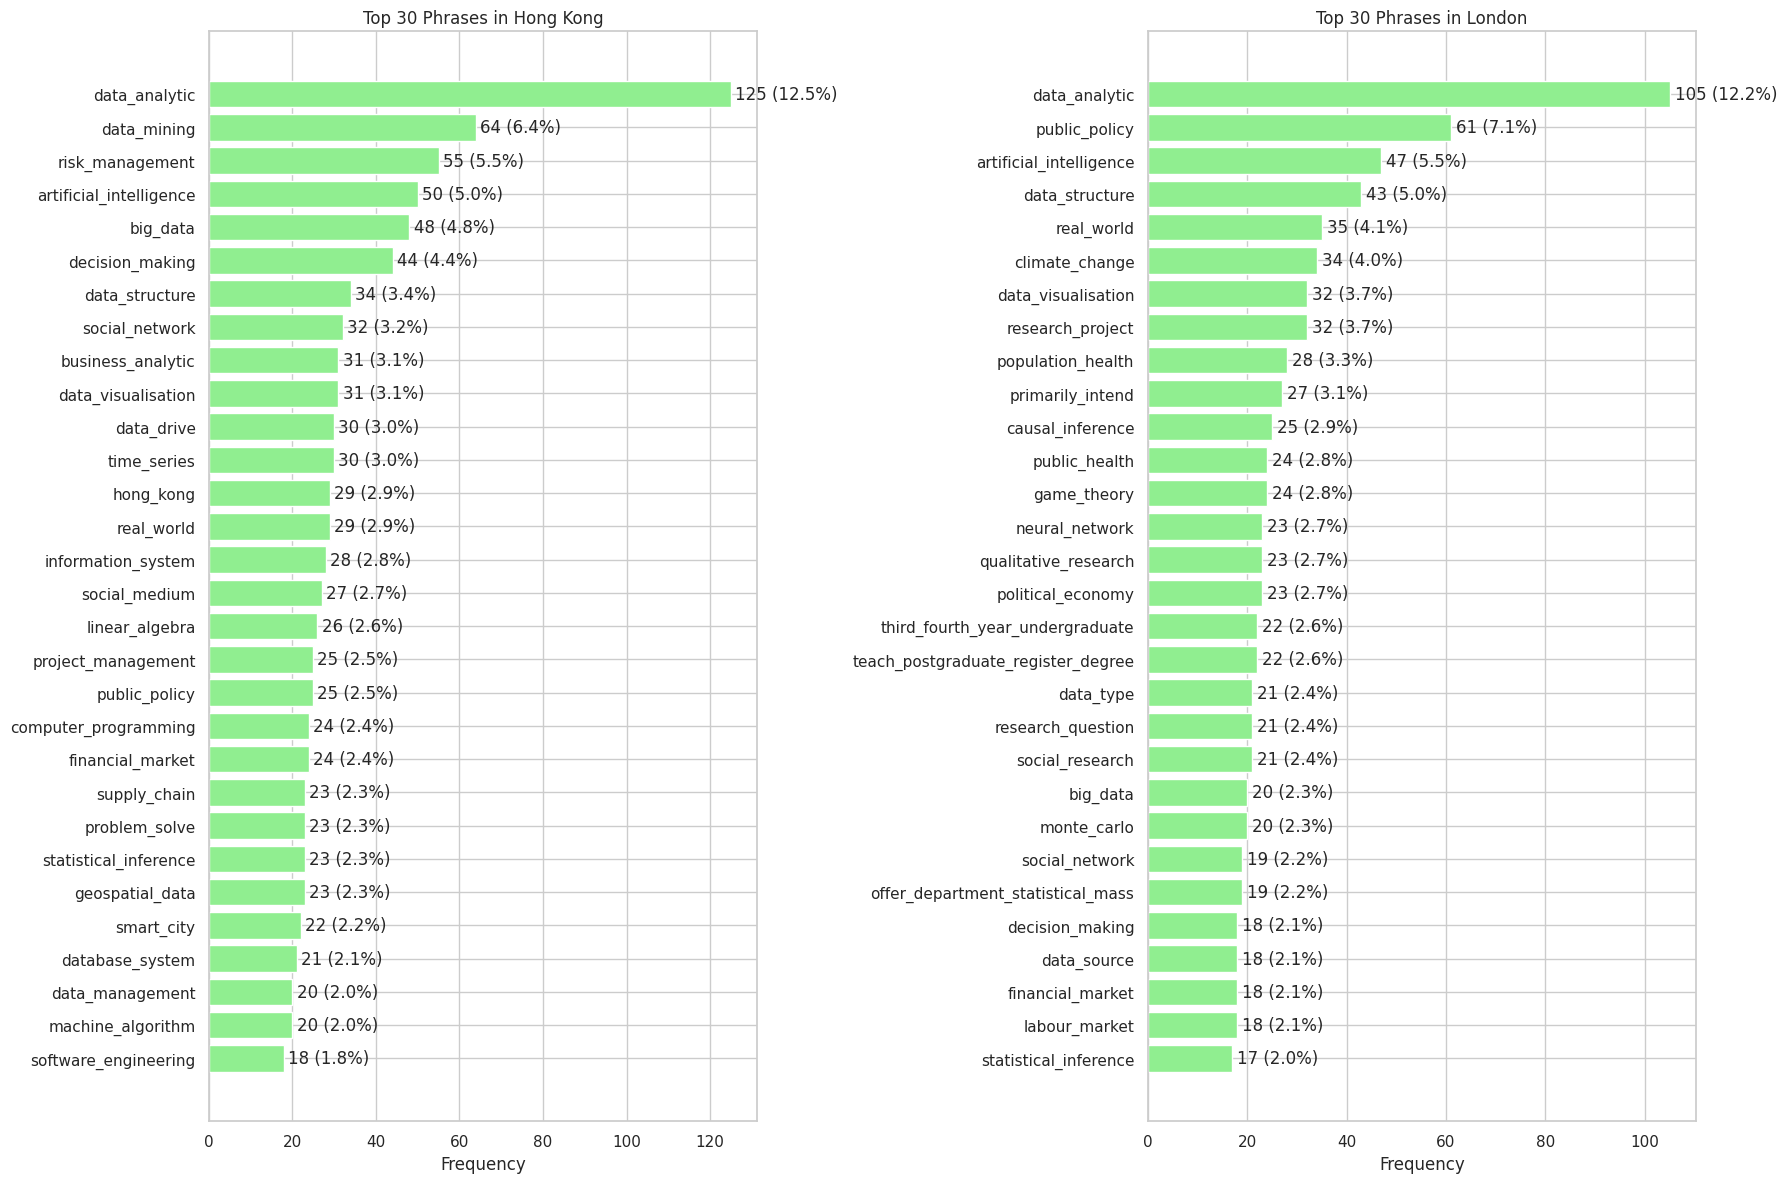

In [51]:
cities = df["city"].unique()
fig, axes = plt.subplots(1, 2, figsize=(18, 12))

for ax, city in zip(axes, cities):
    # Extract multi-word tokens (bigrams/trigrams) for this city
    city_tokens = [token for tokens in df[df["city"]==city]["tokens_final"] for token in tokens if "_" in token]

    counter = Counter(city_tokens)
    top_tokens = counter.most_common(30)

    top_df = pd.DataFrame(top_tokens, columns=["term", "frequency"])
    total_tokens = top_df["frequency"].sum()
    top_df["percent"] = top_df["frequency"] / total_tokens * 100

    # Horizontal bar chart
    ax.barh(top_df["term"], top_df["frequency"], color="lightgreen")

    # Annotate counts and percentages
    for i, row in top_df.iterrows():
        ax.text(row["frequency"] + 1, i, f'{row["frequency"]} ({row["percent"]:.1f}%)', va='center')

    ax.set_title(f"Top 30 Phrases in {city}")
    ax.set_xlabel("Frequency")
    ax.invert_yaxis()

plt.tight_layout()
plt.savefig("Output/top_phrases_by_city.png", dpi=300)
plt.show()